State: x position [m], y position [m], yaw [rad]

\begin{align*}
\textbf{x}_t =
\begin{bmatrix}
    x_t \\
    y_t \\
    \theta_t \\
\end{bmatrix}
\end{align*}

Input: speed [m/s], yaw rate [rad/s]

$$
\textbf{u}_t =
\begin{bmatrix}
    v_t \\
    \omega_t \\
\end{bmatrix}
$$

Motion model (Non-linear):

$$
\textbf{x}_t = \textbf{f} (\textbf{x}_{t-1}, \textbf{u}_t) + \textbf{w} \\
=
\begin{bmatrix}
    x_{t-1} + v_t \Delta t \cos \theta_{t-1} \\
    y_{t-1} + v_t \Delta t \sin \theta_{t-1} \\
    \theta_{t-1} + \omega_t \Delta t \\
\end{bmatrix}
+
\textbf{w}
$$

Therefore, the Jacobian of the motion model function would be:

$$
J_{\textbf{f}} = 
\begin{bmatrix}
    \frac{\partial x_t}{\partial x_{t-1}}, & \frac{\partial x_t}{\partial y_{t-1}}, & \frac{\partial x_t}{\partial \theta_{t-1}} \\
    \frac{\partial y_t}{\partial x_{t-1}}, & \frac{\partial y_t}{\partial y_{t-1}}, & \frac{\partial y_t}{\partial \theta_{t-1}} \\
    \frac{\partial x_t}{\partial \theta_{t-1}}, & \frac{\partial \theta_t}{\partial y_{t-1}}, & \frac{\partial \theta_t}{\partial \theta_{t-1}} \\
\end{bmatrix}
\\
=
\begin{bmatrix}
    1, & 0, & -v_t \Delta t \sin \theta_{t-1} \\
    0, & 1, & v_t \Delta t \cos \theta_{t-1} \\
    0, & 0, & 1 \\
\end{bmatrix}
$$

Observation: x position [m], y position [m]

$$
\textbf{z}_t =
\begin{bmatrix}
    x_t \\
    y_t \\
\end{bmatrix}
$$

In [25]:
import sys
print(sys.version)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters

In [27]:
DELTA_TIME = 0.1 # [s]
END_TIME = 30.0 # [s]

INPUT_COV = np.diag([
    1.0**2, # [m^2/s^2] variance of speed input
    np.deg2rad(30.0)**2 # [rad^2/s^2] variance of yaw rate input
])

GNSS_COV = np.diag([
    0.5**2, # [m^2] variance of x reading
    0.5**2 # [m^2] variance of y reading
])

In [28]:
### Process noise covariance
Q = np.diag([
    0.1**2, # [m^2] variance of x
    0.1**2, # [m^2] variance of y
    np.deg2rad(1.0)**2 # [rad^2] variance of yaw
])

In [29]:
### Observation model matrix
H = np.array([
    [1, 0, 0],
    [0, 1, 0]
])

### Observation noise covariance
R = np.diag([
    1.0**2, # [m^2] variance of x
    1.0**2 # [m^2] variance of y
])

# Functions

In [30]:
### Non-linear
def MotionModel(x_prev, u_curr):
    x_pos_prev = x_prev[0, 0] # [m]
    y_pos_prev = x_prev[1, 0] # [m]
    yaw_prev = x_prev[2, 0] # [rad]

    speed_curr = u_curr[0, 0] # [m/s]
    yaw_rate_curr = u_curr[1, 0] # [rad/s]

    x_curr = np.array([
        [x_pos_prev + speed_curr*DELTA_TIME*math.cos(yaw_prev)],
        [y_pos_prev + speed_curr*DELTA_TIME*math.sin(yaw_prev)],
        [yaw_prev + yaw_rate_curr*DELTA_TIME]
    ])

    return x_curr



def MotionPredict(x_prev_post, u_curr_noisy, P_prev_post):
    yaw_prev = x_prev_post[2, 0] # [rad]
    speed_curr = u_curr_noisy[0, 0] # [m/s]
    
    J_F = np.array([
        [1, 0, -speed_curr*DELTA_TIME*math.sin(yaw_prev)],
        [0, 1, speed_curr*DELTA_TIME*math.cos(yaw_prev)],
        [0, 0, 1]
    ])

    x_curr_prior = MotionModel(x_prev_post, u_curr_noisy)
    P_curr_prior = J_F@P_prev_post@J_F.T + Q

    return x_curr_prior, P_curr_prior

In [31]:
### Linear
def ObservationModel(x_curr):
    z_curr = H@x_curr

    return z_curr



def MeasurementUpdate(x_curr_prior, P_curr_prior, z_curr):
    S = H@P_curr_prior@H.T + R ### Observation residual covariance (Innovation covariance)
    K = (P_curr_prior@H.T)@np.linalg.inv(S) ### Kalman gain

    x_curr_post = x_curr_prior + K@(z_curr - ObservationModel(x_curr_prior))
    P_curr_post = (np.eye(len(x_curr_post)) - K@H)@P_curr_prior
   
    return x_curr_post, P_curr_post

In [32]:
def EKF(x_prev_post, P_prev_post, u_curr_noisy, z_curr):
    x_curr_prior, P_curr_prior = MotionPredict(x_prev_post, u_curr_noisy, P_prev_post)
    x_curr_post, P_curr_post = MeasurementUpdate(x_curr_prior, P_curr_prior, z_curr)

    return x_curr_post, P_curr_post

In [33]:
def Vizualize(xs_GT, xs_DR, xs_est, zs, min_x, max_x, tick_x, min_y, max_y, tick_y):
    assert min_x < 0 and 0 < max_x
    assert min_y < 0 and 0 < max_y

    xs_GT_np = np.array(xs_GT)
    xs_DR_np = np.array(xs_DR)
    xs_est_np = np.array(xs_est)
    zs_np = np.array(zs)

    plt.plot(xs_GT_np[:, 0], xs_GT_np[:, 1], color='blue', label='Ground Truth')
    plt.plot(xs_DR_np[:, 0], xs_DR_np[:, 1], color='black', label='Dead Reckoning')
    plt.plot(xs_est_np[:, 0], xs_est_np[:, 1], color='red', linestyle='dashed', label='Estimation')
    plt.scatter(zs_np[:, 0], zs_np[:, 1], color='green', s=2, label='Observation')

    plt.xticks(np.arange(2*min_x, 2*max_x, tick_x))
    plt.yticks(np.arange(2*min_y, 2*max_y, tick_y))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.grid(True)
    plt.legend(loc='upper left')

    return

# Initialize

In [34]:
t = 0.0

x_GT_init = np.zeros((3, 1)) ### Ground Truth
x_DR_init = np.zeros((3, 1)) ### Dead Reckoning

x_est_init = np.zeros((3, 1))
P_est_init = np.diag([
    1.0**2, # [m^2] variance of x
    1.0**2, # [m^2] variance of y
    1.0**2, # [rad^2] variance of yaw
])

z_init = np.zeros((2, 1))

In [35]:
xs_GT = [x_GT_init]
xs_DR = [x_DR_init]
xs_est = [x_est_init]
zs = [z_init]

# Main loop

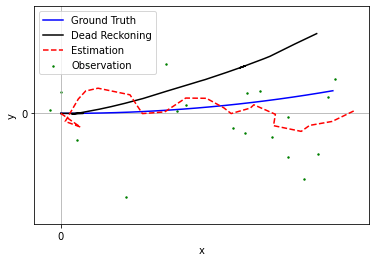

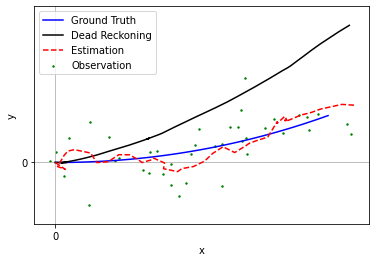

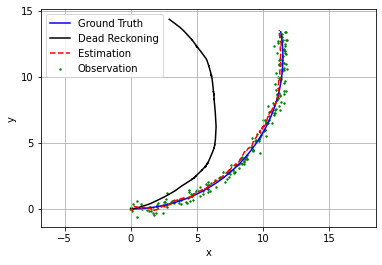

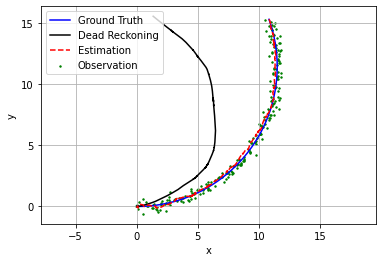

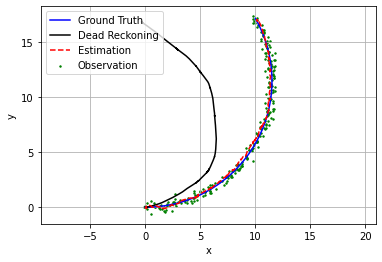

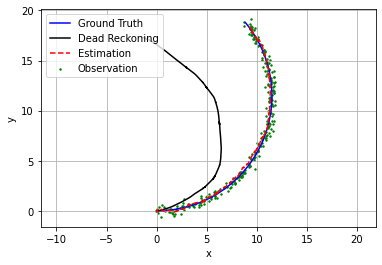

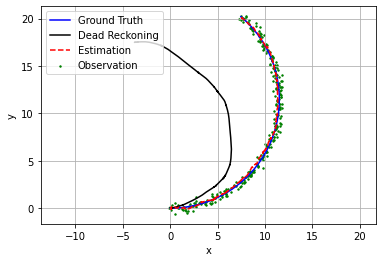

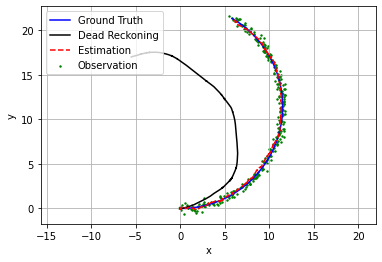

In [36]:
x_GT_prev = x_GT_init
x_DR_prev = x_DR_init
x_est_prev = x_est_init
P_est_prev = P_est_init

while t < END_TIME:
    ### Input command ... NOTE: "u_curr.shape" must be (2, 1), not (2,)
    speed_curr = 1.0 # [m/s]
    yaw_rate_curr = np.deg2rad(5.0) # [m/s]
    u_curr = np.array([
        [speed_curr],
        [yaw_rate_curr],
    ])
    
    ### Ground Truth state
    x_GT_curr = MotionModel(x_GT_prev, u_curr)

    ### Dead Reckoning state
    input_noise = INPUT_COV @ np.random.randn(2, 1)
    u_curr_noisy = u_curr + input_noise
    x_DR_curr = MotionModel(x_DR_prev, u_curr_noisy)

    ### Observation
    gnss_noise = GNSS_COV @ np.random.randn(2, 1)
    z_curr = ObservationModel(x_GT_curr) + gnss_noise

    ### Extended Kalman Filter estimation
    x_est_curr, P_est_curr = EKF(x_est_prev, P_est_prev, u_curr_noisy, z_curr)

    xs_GT.append(x_GT_curr)
    xs_DR.append(x_DR_curr)
    xs_est.append(x_est_curr)
    zs.append(z_curr)

    if np.isclose((t + DELTA_TIME) % 2.0, 0.0, atol=1.0e-5):
        min_x, max_x, tick_x = -15, 15, 5
        min_y, max_y, tick_y = -5, 25, 5
        Vizualize(xs_GT, xs_DR, xs_est, zs, min_x, max_x, tick_x, min_y, max_y, tick_y)
        plt.pause(0.001)

    x_GT_prev = x_GT_curr
    x_DR_prev = x_DR_curr
    x_est_prev = x_est_curr
    P_est_prev = P_est_curr

    t += DELTA_TIME